# Ch4. 特征构建：我能生成新特征吗

我们会探讨如下主题：
- 检查数据集；
- 填充分类特征；
- 编码分类变量；
- 扩展数值特征；
- 针对文本的特征构建。 

## 4.1 检查数据集

In [1]:
import pandas as pd

X = pd.DataFrame({
    'city': ['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'],
    'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
    'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'],
    'quantitative_column':[1, 11, -.5, 10, None, 20]
})

In [2]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


## 4.2 填充分类特征

In [3]:
X.isnull().sum()

city                   1
boolean                1
ordinal_column         0
quantitative_column    1
dtype: int64

In [4]:
X['city'].value_counts().index[0]

'tokyo'

我们注意到，tokyo是频繁出现的城市。知道了应该用哪个值来填充，就可以开始处理了。

In [5]:
X['city'].fillna(X['city'].value_counts().index[0])

0            tokyo
1            tokyo
2           london
3          seattle
4    san francisco
5            tokyo
Name: city, dtype: object

### 4.2.1 自定义填充器

在写代码之前，快速回顾一下机器学习流水线：
- 我们可以用流水线按顺序应用转换和最终的预测器；
- 流水线的中间步骤只能是转换，这意味着它们必须实现fit和transform方法；
- 最终的预测器只需要实现fit方法。

### 4.2.2 自定义分类填充器

In [6]:
# from sklearn.impute import SimpleImputer

# impute = SimpleImputer(strategy='mean')
# X['quantitative_column'] = impute.fit_transform(X[['quantitative_column']])

In [7]:
from sklearn.base import TransformerMixin

class CustomCategoryImputer(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], inplace=True)
        return X
    def fit(self, *_):
        return self

In [8]:
cci = CustomCategoryImputer(cols=['city', 'boolean'])
cci.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


### 4.2.3 自定义定量填充器 

In [9]:
X['quantitative_column'].mean()

8.3

In [10]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [11]:
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer

class CustomQuantitativeImputer(TransformerMixin):
    def __init__(self, cols=None, strategy='mean'):
        self.cols = cols
        self.strategy = strategy
    def transform(self, df):
        X = df.copy()
        impute = SimpleImputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = impute.fit_transform(X[[col]])
        return X
    def fit(self, *_):
        return self

In [12]:
cqi = CustomQuantitativeImputer(cols=['quantitative_column'])
cqi.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


In [13]:
from sklearn.pipeline import Pipeline

cqi = CustomQuantitativeImputer(cols=['quantitative_column'])
cci = CustomCategoryImputer(cols=['city', 'boolean'])
imputer = Pipeline([('quant', cqi), ('category', cci)])
imputer.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,tokyo,no,like,11.0
2,london,no,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,8.3
5,tokyo,yes,dislike,20.0


## 4.3 编码分类变量

### 4.3.1 定类等级的编码

In [14]:
pd.get_dummies(X, columns=['city', 'boolean'])

,ordinal_column,quantitative_column,city_london,city_san francisco,city_seattle,city_tokyo,boolean_no,boolean_yes
0,somewhat like,1.0,0,0,0,1,0,1
1,like,11.0,0,0,0,0,1,0
2,somewhat like,-0.5,1,0,0,0,0,0
3,like,10.0,0,0,1,0,1,0
4,somewhat like,NaN,0,1,0,0,1,0
5,dislike,20.0,0,0,0,1,0,1


In [15]:
# 自定义虚拟变量编码器 
from sklearn.base import TransformerMixin

class CustomDummifier(TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
    def transform(self, df):
        X = df.copy()
        return pd.get_dummies(X, columns=self.cols)
    def fit(self, *_):
        return self

In [16]:
cd = CustomDummifier(cols=['boolean', 'city'])
cd.fit_transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,0,1,0,0,0,1
1,like,11.0,1,0,0,0,0,0
2,somewhat like,-0.5,0,0,1,0,0,0
3,like,10.0,1,0,0,0,1,0
4,somewhat like,NaN,1,0,0,1,0,0
5,dislike,20.0,0,1,0,0,0,1


### 4.3.2 定序等级的编码 

In [17]:
print(X['ordinal_column'])

0    somewhat like
1             like
2    somewhat like
3             like
4    somewhat like
5          dislike
Name: ordinal_column, dtype: object


In [18]:
ordering = ['dislike', 'somewhat like', 'like']
ordering.index('dislike')

0

In [19]:
X['ordinal_column'].map(lambda x: ordering.index(x))

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64

In [20]:
from sklearn.base import TransformerMixin

class CustomEncoder(TransformerMixin):
    def __init__(self, col, ordering=None):
        self.col = col
        self.ordering = ordering
    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(lambda x: self.ordering.index(x))
        return X
    def fit(self, *_):
        return self

In [21]:
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])
ce.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,1,1.0
1,None,no,2,11.0
2,london,None,1,-0.5
3,seattle,no,2,10.0
4,san francisco,no,1,NaN
5,tokyo,yes,0,20.0


### 4.3.3 将连续特征分箱

In [22]:
X['quantitative_column']

0     1.0
1    11.0
2    -0.5
3    10.0
4     NaN
5    20.0
Name: quantitative_column, dtype: float64

In [23]:
pd.cut(X['quantitative_column'], bins=3)

0     (-0.52, 6.333]
1    (6.333, 13.167]
2     (-0.52, 6.333]
3    (6.333, 13.167]
4                NaN
5     (13.167, 20.0]
Name: quantitative_column, dtype: category
Categories (3, interval[float64]): [(-0.52, 6.333] < (6.333, 13.167] < (13.167, 20.0]]

In [24]:
# 不使用标签 
pd.cut(X['quantitative_column'], bins=3, labels=False)

0    0.0
1    1.0
2    0.0
3    1.0
4    NaN
5    2.0
Name: quantitative_column, dtype: float64

In [25]:
from sklearn.base import TransformerMixin

class CustomCutter(TransformerMixin):
    def __init__(self, col, bins, labels=False):
        self.col = col
        self.bins = bins
        self.labels = labels
        
    def transform(self, df):
        X = df.copy()
        X[self.col] = pd.cut(X[self.col], bins=self.bins, labels=self.labels)
        return X
    
    def fit(self, *_):
        return self

In [26]:
cc = CustomCutter(col='quantitative_column', bins=3) 
cc.fit_transform(X)

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,0.0
1,None,no,like,1.0
2,london,None,somewhat like,0.0
3,seattle,no,like,1.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,2.0


### 4.3.4 创建流水线

In [27]:
from sklearn.pipeline import Pipeline

# 填充定类和定量缺失值
cqi = CustomQuantitativeImputer(cols=['quantitative_column'])
cci = CustomCategoryImputer(cols=['city', 'boolean'])
# 设置缺失值填充管道
imputer = Pipeline([('quant', cqi), ('category', cci)])
# 虚拟变量编码器
cd = CustomDummifier(cols=['boolean', 'city'])
# 定序等级的编码器
ce = CustomEncoder(col='ordinal_column', ordering = ['dislike', 'somewhat like', 'like'])
# 连续特征分箱
cc = CustomCutter(col='quantitative_column', bins=3)

# 流水线
pipe = Pipeline([("imputer", imputer), ("dummify", cd), ("encode", ce), ("cut", cc)])

In [28]:
X

,city,boolean,ordinal_column,quantitative_column
0,tokyo,yes,somewhat like,1.0
1,None,no,like,11.0
2,london,None,somewhat like,-0.5
3,seattle,no,like,10.0
4,san francisco,no,somewhat like,NaN
5,tokyo,yes,dislike,20.0


In [29]:
pipe.fit(X)
pipe.transform(X)

,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


## 4.4 扩展数值特征

### 4.4.1 根据胸部加速度计识别动作的数据集

In [30]:
df = pd.read_csv("C:/pwork/Feature-Engineering-Made-Easy/data/activity_recognizer/1.csv", header = None)
df.columns = ['index', 'x', 'y', 'z', 'activity']
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [31]:
df.shape

(162501, 5)

In [32]:
df['activity'].value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
# 空准确率
X = df[['x', 'y', 'z']]
y = df['activity']

knn_params = {
    'n_neighbors': [i for i in range(3, 7)]
}
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, knn_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)

C:\Users\13631\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.7408140649873495 {'n_neighbors': 5}


### 4.4.2 多项式特征

In [35]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 9)

In [36]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


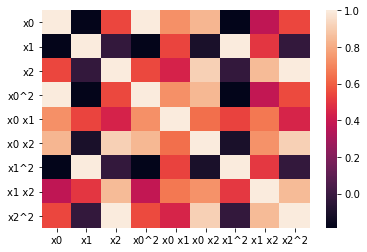

In [37]:
import seaborn as sns
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [38]:
# interaction_only=True的情况
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_poly = poly.fit_transform(X)
X_poly.shape

(162501, 6)

In [39]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0 x1,x0 x2,x1 x2
0,1502.0,2215.0,2153.0,3326930.0,3233806.0,4768895.0
1,1667.0,2072.0,2047.0,3454024.0,3412349.0,4241384.0
2,1611.0,1957.0,1906.0,3152727.0,3070566.0,3730042.0
3,1601.0,1939.0,1831.0,3104339.0,2931431.0,3550309.0
4,1643.0,1965.0,1879.0,3228495.0,3087197.0,3692235.0


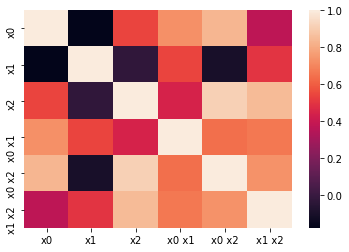

In [40]:
import seaborn as sns
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr())

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

pipe_params = {
    'poly_features__degree': [1, 2, 3],
    'poly_features__interaction_only': [True, False],
    'classify__n_neighbors': [i for i in range(3, 7)],
}

knn = KNeighborsClassifier()
poly = PolynomialFeatures()
pipe = Pipeline([('poly_features', poly), ('classify', knn)])

grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)

C:\Users\13631\AppData\Local\Programs\Python\Python38-32\lib\site-packages\sklearn\model_selection\_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.7408140649873495 {'classify__n_neighbors': 5, 'poly_features__degree': 1, 'poly_features__interaction_only': True}


## 4.5 针对文本的特征构建

### 4.5.1 词袋法

将语料库转换为数值表示（也就是向量化）的常见方法是词袋（bagofwords），其背后的基本思想是：通过单词的出现来描述文档，完全忽略单词在文档中的位置。在它简单的形式中，用一个袋子表示文本，不考虑语法和词序，并将这个袋子视作一个集合，其中重复度高的单词更重要。词袋的3个步骤是：
- 分词（tokenizing）；
- 计数（counting）；
- 归一化（normalizing）。

首先介绍分词。分词过程是用空白和标点将单词分开，将其变为词项。每个可能出现的词项都有一个整数ID。然后是计数。简单地计算文档中词项的出现次数。最后是归一化。将词项在大多数文档中的重要性按逆序排列。

下面了解另外几个向量化方法。

### 4.5.2 CountVectorizer 

In [42]:
import pandas as pd

In [43]:
tweets = pd.read_csv('C:/pwork/Feature-Engineering-Made-Easy/data/twitter_sentiment.csv', encoding='latin1')
tweets.head()

,ItemID,Sentiment,SentimentText
0,1,0,is so sad for my APL frie...
1,2,0,I missed the New Moon trail...
2,3,1,omg its already 7:30 :O
3,4,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,5,0,i think mi bf is cheating on me!!! ...


In [44]:
del tweets['ItemID']
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [45]:
from sklearn.feature_extraction.text import CountVectorizer

X = tweets['SentimentText']
y = tweets['Sentiment']

vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105849)


In [46]:
 # 删除英语停用词（if、a、the, 等等）
from sklearn.feature_extraction.text import CountVectorizer

X = tweets['SentimentText']
y = tweets['Sentiment']

vect = CountVectorizer(stop_words='english')
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105545)


In [47]:
# 只保留至少在 5%文档中出现的单词 
vect = CountVectorizer(min_df=0.05)
_ = vect.fit_transform(X)
print(_.shape)

(99989, 31)


In [48]:
# 只保留至多在 80%文档中出现的单词
vect = CountVectorizer(max_df=0.8)
_ = vect.fit_transform(X)
print(_.shape)

(99989, 105849)


In [49]:
# 包括最多5个单词的短语
vect = CountVectorizer(ngram_range=(1, 5))
_ = vect.fit_transform(X)
print(_.shape) # 特征数爆炸

(99989, 3219557)


In [50]:
vect = CountVectorizer(analyzer='word')  # 默认分析器，划分为单词 
_ = vect.fit_transform(X)
print(_.shape)  

(99989, 105849)


In [51]:
from nltk.stem.snowball import SnowballStemmer

In [52]:
stemmer = SnowballStemmer('english')

stemmer.stem('interesting')

'interest'

In [53]:
def word_tokenize(text, how='lemma'):
    words = text.split(' ') # 按词分词 
    return [stemmer.stem(word) for word in words]

In [54]:
word_tokenize("hello you are very interesting")

['hello', 'you', 'are', 'veri', 'interest']

In [55]:
# 将这个分词器传入分析器参数：
vect = CountVectorizer(analyzer=word_tokenize)
_ = vect.fit_transform(X)
print(_.shape)

(99989, 154397)


CountVectorizer 是一个非常有用的工具，不仅可以扩展特征，还可以将文本转换为数值特征。我们再研究另一个常用的向量化器。 

### 4.5.3 TF-IDF向量化器

In [56]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape, _[0,:].mean())

(99989, 105849) 6.613194267305311e-05


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer()
_ = vect.fit_transform(X)
print(_.shape, _[0,:].mean())

(99989, 105849) 2.1863060975751192e-05


### 4.5.4 在机器学习流水线中使用文本

In [58]:
from sklearn.naive_bayes import MultinomialNB

In [59]:
y.value_counts(normalize=True)

1    0.564632
0    0.435368
Name: Sentiment, dtype: float64

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# 设置流水线参数 
pipe_params = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': [1000, 10000],
    'vect__stop_words': [None, 'english']
}
# 实例化流水线 
pipe = Pipeline([('vect', CountVectorizer()), ('classify', MultinomialNB())])
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

featurizer = FeatureUnion([('tfidf_vect', TfidfVectorizer()), ('count_vect', CountVectorizer())])
_ = featurizer.fit_transform(X)
print(_.shape) # 行数相同，但列数为2倍

In [ ]:
featurizer.set_params(tfidf_vect__max_features=100, count_vect__ngram_range=(1, 2),
                     count_vect__max_features=300)
_ = featurizer.fit_transform(X)
# TfidfVectorizer只保留100个单词，而CountVectorizer保留300个1～2个单词的短语
print(_.shape)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# 设置流水线参数 
pipe_params = {
    'featurizer__count_vect__ngram_range': [(1, 1), (1, 2)],
    'featurizer__count_vect__max_features': [1000, 10000],
    'featurizer__count_vect__stop_words':[None, 'english'],
    'featurizer__tfidf_vect__ngram_range': [(1, 1), (1, 2)],
    'featurizer__tfidf_vect__max_features': [1000, 10000],
    'featurizer__tfidf_vect__stop_words':[None, 'english'],
}

# 实例化流水线 
pipe = Pipeline([('featurizer', featurizer), ('classify', MultinomialNB())])
grid = GridSearchCV(pipe, pipe_params)
grid.fit(X, y)
print(grid.best_score_, grid.best_params_)